In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
import pandas as pd
import DatasetGenerator as DG
DG.generate()
pd.options.display.max_rows = 9999
df = pd.read_csv('in_out.csv')

DG.train_splitter(0.7)

[10, 'C:\\Users\\Ante\\Documents\\Faks\\neuronske\\VineClass\\dataset\\Grape\\Grape___Esca_(Black_Measles)\\25da5b3c-b105-4471-9ddc-aed768164424___FAM_B.Msls 3925.JPG', 'esca']


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'cooked_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: (torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4))
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


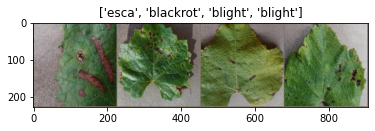

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
import datetime

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print(datetime.datetime.now())
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def softmax_boosted(inp):
    inp = inp.tolist()
    out = []
    am = min([min(inp),0])
    am = am * -1
    for i,v in enumerate(inp):
        out.append(v + am)
        
    return (torch.nn.functional.softmax(torch.FloatTensor(out), dim=0).tolist())

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    file_names = [path for path, label in image_datasets['val'].imgs]  # get file names
    print(class_names)
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                print(softmax_boosted(outputs[images_so_far%4]))
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 4.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
print(num_ftrs)
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

512


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
2023-01-09 20:09:20.301597
----------
train Loss: 2.0428 Acc: 0.4553
val Loss: 2.4038 Acc: 0.4860

Epoch 1/24
2023-01-09 20:09:55.132659
----------
train Loss: 1.1573 Acc: 0.5246
val Loss: 1.0883 Acc: 0.6617

Epoch 2/24
2023-01-09 20:10:27.244224
----------
train Loss: 0.9709 Acc: 0.5960
val Loss: 0.5608 Acc: 0.8194

Epoch 3/24
2023-01-09 20:10:59.424942
----------
train Loss: 0.8272 Acc: 0.6663
val Loss: 0.8975 Acc: 0.6297

Epoch 4/24
2023-01-09 20:11:31.544267
----------
train Loss: 0.6846 Acc: 0.7391
val Loss: 0.4060 Acc: 0.8522

Epoch 5/24
2023-01-09 20:12:03.631482
----------
train Loss: 0.6126 Acc: 0.7532
val Loss: 0.4403 Acc: 0.8563

Epoch 6/24
2023-01-09 20:12:35.766505
----------
train Loss: 0.5335 Acc: 0.7968
val Loss: 0.2783 Acc: 0.9294

Epoch 7/24
2023-01-09 20:13:08.078715
----------
train Loss: 0.3652 Acc: 0.8646
val Loss: 0.2426 Acc: 0.9212

Epoch 8/24
2023-01-09 20:13:40.238439
----------
train Loss: 0.3127 Acc: 0.8808
val Loss: 0.2911 Acc: 0.8834

Epoch 9/24

['blackrot', 'blight', 'esca', 'healthy']
[0.002535601146519184, 0.00043543174979276955, 0.9969342947006226, 9.477676940150559e-05]


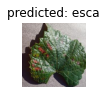

[0.9780108332633972, 0.010943934321403503, 0.00969676859676838, 0.0013485560193657875]


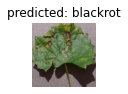

[0.9948864579200745, 0.001499498263001442, 0.003612044034525752, 1.9645055999717442e-06]


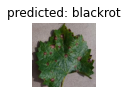

[0.9644348621368408, 0.0020943412091583014, 0.03343900293111801, 3.180981002515182e-05]


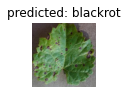

[0.8241025805473328, 0.15118622779846191, 0.023302221670746803, 0.0014089664909988642]


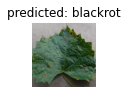

[0.00015258336497936398, 0.9998410940170288, 3.007527311638114e-06, 3.3398157484043622e-06]


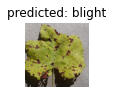

In [9]:
visualize_model(model_ft)

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
2023-01-09 20:22:59.756954
----------
train Loss: 3.2582 Acc: 0.6930
val Loss: 1.0485 Acc: 0.8686

Epoch 1/24
2023-01-09 20:23:22.230965
----------
train Loss: 2.2624 Acc: 0.7982
val Loss: 0.5327 Acc: 0.9319

Epoch 2/24
2023-01-09 20:23:44.882663
----------
train Loss: 2.7324 Acc: 0.7823
val Loss: 0.7231 Acc: 0.9351

Epoch 3/24
2023-01-09 20:24:08.477035
----------
train Loss: 2.4059 Acc: 0.8080
val Loss: 0.2733 Acc: 0.9696

Epoch 4/24
2023-01-09 20:24:33.619803
----------
train Loss: 2.7829 Acc: 0.8017
val Loss: 0.4645 Acc: 0.9524

Epoch 5/24
2023-01-09 20:24:57.070703
----------
train Loss: 2.8996 Acc: 0.7954
val Loss: 1.3267 Acc: 0.8982

Epoch 6/24
2023-01-09 20:25:19.756873
----------
train Loss: 2.7978 Acc: 0.8027
val Loss: 1.2492 Acc: 0.8982

Epoch 7/24
2023-01-09 20:25:42.500073
----------
train Loss: 1.5926 Acc: 0.8576
val Loss: 0.3185 Acc: 0.9647

Epoch 8/24
2023-01-09 20:26:05.351624
----------
train Loss: 1.5425 Acc: 0.8492
val Loss: 0.3530 Acc: 0.9631

Epoch 9/24

['blackrot', 'blight', 'esca', 'healthy']
[1.8581217636947074e-42, 1.0, 1.175357404725966e-36, 1.7532675041539065e-38]


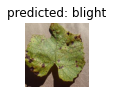

[1.0, 6.438103121749492e-34, 1.7727538025623192e-27, 1.5878978224150581e-28]


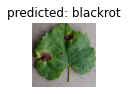

[1.0, 1.1134222630004548e-20, 2.2065532564701974e-22, 8.63147459562599e-21]


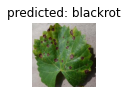

[6.184254327478124e-37, 1.0, 2.484895186536244e-34, 7.87485792230706e-37]


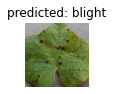

[1.2873064854352191e-15, 3.167826372415157e-30, 1.654212598781131e-25, 1.0]


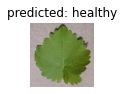

[1.2873038349417414e-19, 3.9822494837496025e-31, 1.0, 2.08511197480135e-20]


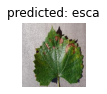

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()